# 05 Logistic regression baseline

In [1]:
%matplotlib inline

import os
import pandas as pd
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression

In [2]:
# Some global variables
features_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/'
img_basepath = '/data/ml_course/04_Applied_Machine_Learning_2/11_Course_project/Swissroads_imgs/'

In [3]:
# Load data
def load_data(features_basepath, features_file, one_hot_encoding=False):
    with np.load(os.path.join(features_basepath, features_file), allow_pickle=False) as npz_file:
        data = dict(npz_file.items())
        
    X = data['data']
    if one_hot_encoding:
        y = data['labels']
    else:
        y = np.where(data['labels'] == 1)[1]
    names = data['names']
    filenames = data['filenames']
    
    return X, y, names, filenames 

In [4]:
X_tr, y_tr, names, fn_tr = load_data(features_basepath, 'Swissroads_train.npz', one_hot_encoding=False)
X_va, y_va, _, fn_va = load_data(features_basepath, 'Swissroads_valid.npz', one_hot_encoding=False)
X_te, y_te, _, fn_te = load_data(features_basepath, 'Swissroads_test.npz', one_hot_encoding=False)
print(X_tr.shape, y_tr.shape)
print(X_va.shape, y_va.shape)
print(X_te.shape, y_te.shape)

(280, 1280) (280,)
(139, 1280) (139,)
(50, 1280) (50,)


In [5]:
X = np.append(X_tr, X_va, axis=0)
y = np.append(y_tr, y_va, axis=0)
print(X.shape, y.shape)

(419, 1280) (419,)


## Logistic regression baseline

In [6]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(None, y_tr)
print('Test accuracy: {:.2f}%'.format(100*dummy.score(None, y_te)))

Test accuracy: 24.00%


## Logistic regression cross-validation

In [7]:
# Create 5 test folds
n_folds = 5
n_tr = y_tr.shape[0]
n_va = int(y_va.shape[0]/n_folds)
test_fold = np.zeros(y.shape[0])
test_fold[:n_tr] = -1

test_fold[n_tr:n_tr+n_va] = 0
test_fold[n_tr+n_va:n_tr+2*n_va] = 1
test_fold[n_tr+2*n_va:n_tr+3*n_va] = 2
test_fold[n_tr+3*n_va:n_tr+4*n_va] = 3
test_fold[n_tr+4*n_va:] = 4

# create five folds with the validation data
ps = PredefinedSplit(test_fold)
ps.get_n_splits()

5

In [8]:
# Create pipeline
pipe = Pipeline([
    ('scaler', None),
    ('logreg', LogisticRegression())
])

# Create cross-validation object
Cs = np.logspace(-4, 4, num=20)
grids = [{
    'logreg__multi_class': ['ovr'],
    'logreg__solver': ['liblinear'],
    'logreg__C': Cs
}, {
    'logreg__multi_class': ['multinomial'],
    'logreg__solver': ['saga'],
    'logreg__C': Cs
}]

grid_cv = GridSearchCV(pipe, grids, cv=ps, return_train_score=True, verbose=True, n_jobs=-1)

# Fit estimator
grid_cv.fit(X, y)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   54.4s finished
/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  4,  4])),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', None), ('logreg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'logreg__multi_class': ['ovr'], 'logreg__solver': ['liblinear'], 'logreg__C': array([1.00000e-04, 2.63665e-04, 6.95193e-04, 1.83298e-03, 4.83293e-03,
       1.27427e-02, 3.35982e-02, 8.85867e-02, 2.33572e-01, 6.15848e-01,
       1.62378e+00, 4.28133e+00, 1.12884e+01, 2.97635e+01, 7.8476...2.97635e+01, 7.84760e+01,
       2.06914e+02, 5.45559e+02, 1.43845e+03, 3.79269e+03, 1.00000e+04])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scor

In [9]:
# Collect results in a DataFrame
logreg_results = pd.DataFrame({
    'strategy': grid_cv.cv_results_['param_logreg__multi_class'],
    'C': grid_cv.cv_results_['param_logreg__C'],
    'mean_tr': grid_cv.cv_results_['mean_train_score'],
    'mean_te': grid_cv.cv_results_['mean_test_score'],
    'std_te': grid_cv.cv_results_['std_test_score']
})

# Ten best combinations according to the mean test score
logreg_results.sort_values(by='mean_te', ascending=False).head(10)

,strategy,C,mean_tr,mean_te,std_te
3,ovr,0.00183298,0.926383,0.920863,0.058810
24,multinomial,0.00483293,0.978529,0.906475,0.060323
5,ovr,0.0127427,0.989275,0.906475,0.060323
33,multinomial,29.7635,1.000000,0.906475,0.060323
39,multinomial,10000,1.000000,0.899281,0.064082
29,multinomial,0.615848,1.000000,0.899281,0.064082
25,multinomial,0.0127427,0.992847,0.899281,0.064082
26,multinomial,0.0335982,0.997959,0.899281,0.064082
27,multinomial,0.0885867,1.000000,0.899281,0.064082
28,multinomial,0.233572,1.000000,0.899281,0.064082


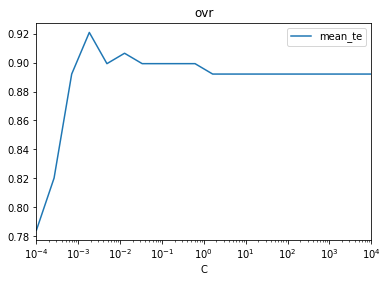

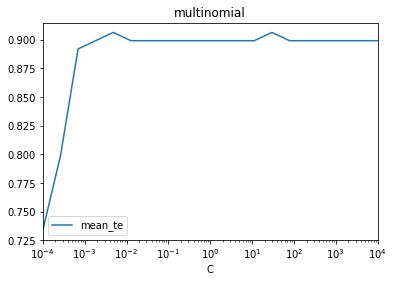

In [10]:
# Plot test curve
logreg_results[logreg_results['strategy'] == 'ovr'].plot(x='C', y='mean_te', logx=True, title='ovr')
plt.show()

# Plot test curve
logreg_results[logreg_results['strategy'] == 'multinomial'].plot(x='C', y='mean_te', logx=True, title='multinomial')
plt.show()

In [11]:
# Report test score
acc_logreg = 100*grid_cv.score(X_te, y_te)
print('Test accuracy: {:.2f}%'.format(acc_logreg))

Test accuracy: 96.00%


In [12]:
# Store result
df_acc = pd.DataFrame({'model': 'logistic', 'test_accuracy': acc_logreg}, index=[0])
df_acc.to_csv('acc_logistic.csv', index=False)

## Probabilities for selected images

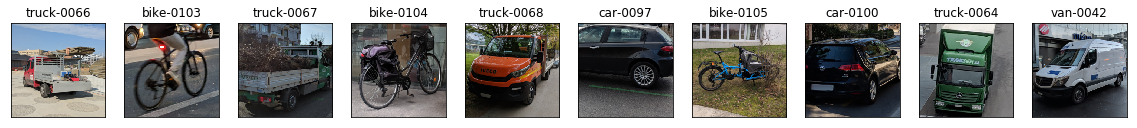

In [13]:
fig, axes = plt.subplots(ncols=10, nrows=1, figsize=(20, 2))

img_names = []
prob_data = np.empty((10, names.size))
inds_te = []
for i in range(10):
    # select image from test dataset
    ind_te = np.random.randint(0, fn_te.size)
    img_te_path = os.path.join(img_basepath+'/test/', fn_te[ind_te])
    img_te = Image.open(img_te_path)
    
    img_name, _ = os.path.splitext(os.path.basename(img_te_path))
    prob_data[i, :] = grid_cv.predict_proba(X_te[ind_te, :].reshape(1, -1))[0]
    img_names.append(img_name)
    inds_te.append(ind_te)
    
    # Plot images
    axes[i].imshow(img_te)
    axes[i].set_title(img_name)
    axes[i].set_xticks([])
    axes[i].set_yticks([])
plt.show()

In [14]:
# Collect results in a DataFrame
probs_results = pd.DataFrame(prob_data, index=img_names, columns=names)
probs_results.round(2)

,bike,car,motorcycle,other,truck,van
truck-0066,0.04,0.08,0.05,0.25,0.48,0.11
bike-0103,0.65,0.05,0.20,0.05,0.03,0.03
truck-0067,0.03,0.10,0.04,0.22,0.51,0.11
bike-0104,0.69,0.05,0.13,0.05,0.05,0.04
truck-0068,0.04,0.14,0.06,0.18,0.41,0.16
car-0097,0.06,0.63,0.06,0.07,0.05,0.14
bike-0105,0.45,0.07,0.23,0.12,0.07,0.05
car-0100,0.03,0.80,0.03,0.06,0.03,0.06
truck-0064,0.06,0.09,0.13,0.24,0.32,0.16
van-0042,0.07,0.10,0.06,0.11,0.28,0.37


## New estimator

In [15]:
# Clone best estimator
logreg2 = clone(grid_cv.best_estimator_)
logreg2.get_params()

{'memory': None,
 'steps': [('scaler', None),
  ('logreg',
   LogisticRegression(C=0.0018329807108324356, class_weight=None, dual=False,
             fit_intercept=True, intercept_scaling=1, max_iter=100,
             multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
             solver='liblinear', tol=0.0001, verbose=0, warm_start=False))],
 'scaler': None,
 'logreg': LogisticRegression(C=0.0018329807108324356, class_weight=None, dual=False,
           fit_intercept=True, intercept_scaling=1, max_iter=100,
           multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
           solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'logreg__C': 0.0018329807108324356,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblin

In [16]:
# Change regularization strength
logreg2.set_params(logreg__C=0.001)
logreg2.get_params()

{'memory': None,
 'steps': [('scaler', None),
  ('logreg',
   LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='ovr',
             n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
             tol=0.0001, verbose=0, warm_start=False))],
 'scaler': None,
 'logreg': LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr',
           n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
           tol=0.0001, verbose=0, warm_start=False),
 'logreg__C': 0.001,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__max_iter': 100,
 'logreg__multi_class': 'ovr',
 'logreg__n_jobs': None,
 'logreg__penalty': 'l2',
 'logreg__random_state': None,
 'logreg__solver': 'liblinear',
 'logreg__tol': 0.0001,
 'logreg__verbose'

In [17]:
# Fit estimator
logreg2.fit(X_tr, y_tr)

Pipeline(memory=None,
     steps=[('scaler', None), ('logreg', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False))])

In [18]:
prob_data2 = np.empty((10, names.size))
for i, ind_te in enumerate(inds_te):
    prob_data2[i, :] = logreg2.predict_proba(X_te[ind_te, :].reshape(1, -1))[0]

# Collect results in a DataFrame
probs_results = pd.DataFrame(prob_data2, index=img_names, columns=names)
probs_results.round(2)

,bike,car,motorcycle,other,truck,van
truck-0066,0.07,0.13,0.10,0.21,0.36,0.13
bike-0103,0.49,0.09,0.21,0.08,0.06,0.05
truck-0067,0.07,0.14,0.09,0.19,0.38,0.13
bike-0104,0.53,0.08,0.16,0.09,0.08,0.07
truck-0068,0.08,0.17,0.11,0.18,0.30,0.16
car-0097,0.10,0.46,0.10,0.10,0.10,0.14
bike-0105,0.35,0.11,0.23,0.13,0.11,0.08
car-0100,0.07,0.63,0.07,0.09,0.07,0.08
truck-0064,0.10,0.13,0.16,0.20,0.26,0.15
van-0042,0.11,0.15,0.10,0.14,0.25,0.26


As expected, changing the regularization strength, change the probabilities of each image. Since the grid search yelded the best probabilities the accuracy of the estimator gets worst.